In [ ]:
import pandas as pd
from datetime import datetime

Reading in MSP data, using ZULU time variable to create a date and time stamp

In [4]:
msp_data = pd.read_csv("../clean/mu_clean.csv",index_col=0)

msp_data['Fault Date'] = pd.to_datetime(msp_data['ZULU_Time'].str.split(" ", n = 2, expand = True)[1])

msp_data['Fault Time'] = pd.to_datetime(msp_data['ZULU_Time'].str.split(" ", n = 2, expand = True)[2], format = '%H:%M:%S:%f').dt.time


/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
msp_data.head()

,Aircraft,Squadron,Lot,MSP,ZULU_Time,Flight_Mode,Fault Date,Fault Time
0,1,HH,100,ZJMZTL,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
1,1,HH,100,JDJDMQ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
2,1,HH,100,RTVBHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
3,1,HH,100,RTUXHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
4,1,HH,100,RTUXMZ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39


Reading in MAF data, converting recevied and completed dates to datetime objects

In [6]:
maf_data = pd.read_csv("../clean/maf_clean.csv", index_col = 0)

maf_data['Received Date'] = pd.to_datetime(maf_data['Received Date'])

maf_data['Completion Date'] = pd.to_datetime(maf_data['Completion Date'])

In [7]:
maf_data.head()

,Job Code,Aircraft,Transaction Code,Malfunction Code,Action Taken Code,Description of Problem,Correction of Problem,Received Date,Completion Date,Corrosion,Bare Metal,Corrosion Prevention Treatment,Routine Maintenance,Unscheduled Maintenance,Mission-Related Maintenance,Failure
0,0NGHY44WC8118573,42,11,0,N,Perform system or component checks,Completed the component or system test,2012-04-26,2014-02-27,False,False,False,True,False,False,False
1,0NGHY45WC8118591,42,11,0,N,Perform system or component checks,Completed the component or system test,2012-04-26,2014-02-27,False,False,False,True,False,False,False
2,0NGHY46WC8118581,42,11,0,N,Perform a periodic inspection,Completed the inspection,2012-04-26,2014-02-27,False,False,False,True,False,False,False
3,0NGHY47WC8118577,42,11,0,N,Perform a periodic inspection,Completed the inspection,2012-04-26,2014-02-27,False,False,False,True,False,False,False
4,0NGHY48WC8118586,42,11,0,N,Perform a periodic inspection,Completed the inspection,2012-04-26,2014-02-27,False,False,False,True,False,False,False


Creating a dataset of maintenance jobs that specifically targeted corrosion: using the T/F indicators for Corrosion, Bare Metal and Corrosion Prevension

In [8]:
corrosion_actions = maf_data[maf_data['Corrosion']| maf_data['Bare Metal'] | maf_data['Corrosion Prevention Treatment']]

Adding a 'year' variable to join MAF/MSP data on aircraft and year

In [9]:
corrosion_actions["action_year"] = pd.DatetimeIndex(corrosion_actions['Completion Date']).year

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
msp_data['action_year'] = pd.DatetimeIndex(msp_data['Fault Date']).year

Due to the size of the data: taking a random sample of 10,000 jobs that targeted corrosion

In [12]:
corrosion_actions = corrosion_actions.sample(10000, random_state = 35, axis = 0)

Joining MAF actions with MSP error code data on aircraft and year

In [13]:
combined_data = corrosion_actions.drop(['Transaction Code', 'Malfunction Code', 'Action Taken Code', 'Description of Problem', 'Correction of Problem', 'Routine Maintenance', 'Unscheduled Maintenance', 'Mission-Related Maintenance', 'Failure'], axis = 1).merge(msp_data[['Aircraft', 'action_year', 'MSP', 'Flight_Mode', 'Fault Date']], how = 'left', on = ['Aircraft', 'action_year'])

Creating a time window of interest: for the predictive model, we will focuse on the error code frequency 30 days prior to the received date.  To examine the change in frequency for MSP codes before and after corrosion corrective maintenance, we will add a time window 30 days after the completed dates.  This time window can be adjusted to examine model performance

In [14]:
combined_data['before_window'] = combined_data['Received Date'] - pd.DateOffset(months = 1)

combined_data['after_window'] = combined_data['Completion Date'] + pd.DateOffset(months = 1)

Filtering out MSP error codes that occured outside of the 30 day windows previously discussed

In [15]:
combined_data = combined_data[(combined_data['Fault Date'] > combined_data['before_window']) & (combined_data['Fault Date'] < combined_data['after_window'])]

Adding a variable 'Pre' that indicates whether the MSP error code happened before or after the maintenance action.  This will be used to calculate frequency changes of the MSP codes

In [16]:
combined_data['Pre'] = combined_data['Fault Date'] < combined_data['Completion Date']

Removing MSP codes within service window: the data description mentioned sometimes technicians would try to replicate errors, which would inflate MSP frequency.  For that Reason we will remove MSP codes that happened within the service window.

In [17]:
combined_data = combined_data[(combined_data['Fault Date'] > combined_data['Completion Date']) | (combined_data['Fault Date'] < combined_data['Received Date'])]

Adding an indicator variable to count MSP code frequency

In [21]:
combined_data['row'] = True

In [22]:
combined_data.head()

,Job Code,Aircraft,Received Date,Completion Date,Corrosion,Bare Metal,Corrosion Prevention Treatment,action_year,MSP,Flight_Mode,Fault Date,before_window,after_window,Pre,row
242,36MSVQWAA8271517,10,2012-09-27,2012-09-27,True,False,False,2012,HPTLNV,EngineTurn,2012-09-01,2012-08-27,2012-10-27,True,True
243,36MSVQWAA8271517,10,2012-09-27,2012-09-27,True,False,False,2012,HPFVTL,EngineTurn,2012-09-01,2012-08-27,2012-10-27,True,True
244,36MSVQWAA8271517,10,2012-09-27,2012-09-27,True,False,False,2012,HPTLJD,EngineTurn,2012-09-01,2012-08-27,2012-10-27,True,True
245,36MSVQWAA8271517,10,2012-09-27,2012-09-27,True,False,False,2012,HPTLHP,EngineTurn,2012-09-01,2012-08-27,2012-10-27,True,True
246,36MSVQWAA8271517,10,2012-09-27,2012-09-27,True,False,False,2012,HPTLNV,EngineTurn,2012-09-01,2012-08-27,2012-10-27,True,True


Counting the MSP frequency pre and post the maintenance action for corrosion

In [23]:
msp_counts = combined_data[['Job Code', 'MSP', 'Pre', 'row']].groupby(['Job Code', 'MSP', 'Pre']).count().reset_index()

Finding codes to focus on (in builidng a classifier) based on the difference in frequency before and after the corrective action

In [24]:
msp_pre = combined_data.query('Pre == True').groupby('MSP')[['row']].count().reset_index().rename(columns = {'row': 'pre'})

In [25]:
msp_post = combined_data.query('Pre == False').groupby('MSP')[['row']].count().reset_index().rename(columns = {'row': 'post'})

In [26]:
msp_diff = msp_post.merge(msp_pre, how = 'left', on = 'MSP')

In [27]:
msp_diff['diff'] = msp_diff['pre'] - msp_diff['post']

The plot below represents the top 20 MSP codes with the largest difference in frequency pre/post corrective actions

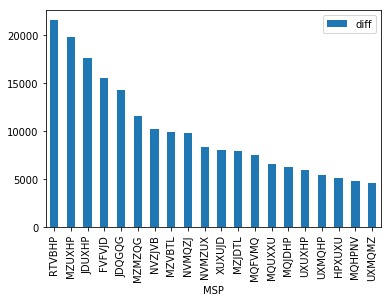

In [29]:
msp_diff.sort_values('diff', ascending=False).reset_index().head(20).plot.bar(x = 'MSP', y = 'diff');

In [30]:
msp_interest = msp_diff.sort_values('diff', ascending=False).reset_index().head(20)['MSP']

In [31]:
msp_interest

0     RTVBHP
1     MZUXHP
2     JDUXHP
3     FVFVJD
4     JDQGQG
5     MZMZQG
6     NVZJVB
7     MZVBTL
8     NVMQZJ
9     NVMZUX
10    XUXUJD
11    MZJDTL
12    MQFVMQ
13    MQUXXU
14    MQJDHP
15    UXUXHP
16    UXMQHP
17    HPXUXU
18    MQHPNV
19    UXMQMZ
Name: MSP, dtype: object

Filtering MSP codes of interest, saving the result to a csv for visualizations

In [32]:
msp_counts[msp_counts['MSP'].isin(msp_interest)].to_csv('../clean/MSP_freq.csv', index = False)

Creating a dataset of MSP codes of interest frequency prior to corrective action, filling in NA values with 0.  The indicator 'corrosion' is True, as these maintenance actions targeted corrosion

In [33]:
corrosion = msp_counts[msp_counts['MSP'].isin(msp_interest)].query('Pre').drop('Pre', axis = 1).pivot(index = 'Job Code', columns = 'MSP', values = 'row').fillna(0.0).reset_index()

corrosion['corrosion'] = True

corrosion.drop('Job Code', axis = 1, inplace = True)

In [34]:
corrosion.tail()

MSP,FVFVJD,HPXUXU,JDQGQG,JDUXHP,MQFVMQ,MQHPNV,MQJDHP,MQUXXU,MZJDTL,MZMZQG,...,MZVBTL,NVMQZJ,NVMZUX,NVZJVB,RTVBHP,UXMQHP,UXMQMZ,UXUXHP,XUXUJD,corrosion
6964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,True
6965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,True
6966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,True
6967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,True
6968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


To balance class labels in the dataset, we will create a dataset of non-corrosion maintence actions, and estimate the frequency of the MSP codes of interest 30 days prior to the received date using the same approach as the corrosion actions.  We will then use MSP code frequency to predict whether the maintenance action targets target corrosion, which could be useful in altering technicians that corrosion could be an issue to address.

In [40]:
non_corrosion_actions = maf_data[~(maf_data['Corrosion'] | maf_data['Bare Metal'] | maf_data['Corrosion Prevention Treatment'])].sample(30000, axis = 0, random_state = 35)

In [41]:
non_corrosion_actions["action_year"] = pd.DatetimeIndex(non_corrosion_actions['Completion Date']).year

In [42]:
combined_data_non = non_corrosion_actions.drop(['Transaction Code', 'Malfunction Code', 'Action Taken Code', 'Description of Problem', 'Correction of Problem', 'Routine Maintenance', 'Unscheduled Maintenance', 'Mission-Related Maintenance', 'Failure'], axis = 1).merge(msp_data[['Aircraft', 'action_year', 'MSP', 'Fault Date']], how = 'left', on = ['Aircraft', 'action_year'])


In [43]:
combined_data_non['before_window'] = combined_data_non['Received Date'] - pd.DateOffset(months = 1)

combined_data_non['after_window'] = combined_data_non['Completion Date'] + pd.DateOffset(months = 1)

In [44]:
combined_data_non = combined_data_non[(combined_data_non['Fault Date'] > combined_data_non['before_window']) & (combined_data_non['Fault Date'] < combined_data_non['after_window'])]


In [45]:
combined_data_non['Pre'] = combined_data_non['Fault Date'] < combined_data_non['Completion Date']

In [46]:
combined_data_non = combined_data_non[(combined_data_non['Fault Date'] > combined_data_non['Completion Date']) | (combined_data_non['Fault Date'] < combined_data_non['Received Date'])]

In [47]:
combined_data_non['row'] = True

non_msp_counts = combined_data_non[['Job Code', 'MSP', 'Pre', 'row']].groupby(['Job Code', 'MSP', 'Pre']).count().reset_index()

In [48]:
non_corrosion = non_msp_counts[non_msp_counts['MSP'].isin(msp_interest)].query('Pre').drop('Pre', axis = 1).pivot(index = 'Job Code', columns = 'MSP', values = 'row').fillna(0.0).reset_index()

non_corrosion['corrosion'] = False

non_corrosion.drop('Job Code', axis = 1, inplace = True)

Again due to the size of the data, we will take a random sample of the maintenance actions to combine with our corrosion maintenance actions.

In [51]:
non_corrosion = non_corrosion.sample(7000, axis = 0, random_state=35)

Next we will combine the data into one file, save to a csv and use a few different Machine Learning algorithms to try to classify whether the maintenance action is for corrosion or not

In [54]:
non_corrosion.append(corrosion).to_csv('../clean/predict_corrosive.csv', index = False)